In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
import sys
import datetime
from decimal import Decimal
from snowflake.snowpark.session import Session
sys.path.append('./test')
from parameters import CONNECTION_PARAMETERS

### Connect to Snowflake and run SQL in Snowflake

In [3]:
session = Session.builder.configs(CONNECTION_PARAMETERS).create()
print(session.sql('show tables').collect()[0].get_string(1))

BOSTON


### Create a dataframe from a Snowflake table

In [4]:
df = session.table("boston")
df.show(10)

------------------------------------------------------------------------------------------------------------------------------
|"CRIM"   |"ZN"  |"INDUS"  |"CHAS"  |"NOX"  |"RM"   |"AGE"  |"DIS"   |"RAD"  |"TAX"  |"PTRATIO"  |"B"     |"LSTAT"  |"MEDV"  |
------------------------------------------------------------------------------------------------------------------------------
|0.00632  |18.0  |2.31     |0.0     |0.538  |6.575  |65.2   |4.09    |1.0    |296.0  |15.3       |396.9   |4.98     |24.0    |
|0.02731  |0.0   |7.07     |0.0     |0.469  |6.421  |78.9   |4.9671  |2.0    |242.0  |17.8       |396.9   |9.14     |21.6    |
|0.02729  |0.0   |7.07     |0.0     |0.469  |7.185  |61.1   |4.9671  |2.0    |242.0  |17.8       |392.83  |4.03     |34.7    |
|0.03237  |0.0   |2.18     |0.0     |0.458  |6.998  |45.8   |6.0622  |3.0    |222.0  |18.7       |394.63  |2.94     |33.4    |
|0.06905  |0.0   |2.18     |0.0     |0.458  |7.147  |54.2   |6.0622  |3.0    |222.0  |18.7       |396.9   |5.33

### Dataframe operations

In [5]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [6]:
from snowflake.snowpark.functions import avg, col
df.filter((df.DIS >= 5) & (df["CHAS"] == 1)).agg(avg(col("MEDV"))).show()

INFO:snowflake.snowpark.internal.server_connection:Execute query [queryID: 019e3325-0003-188d-0000-00040076248a]  SELECT  *  FROM ( SELECT AVG("MEDV") AS "AVG(MEDV)" FROM ( SELECT  *  FROM ( SELECT  *  FROM (boston)) WHERE (("DIS" >= 5:: bigint) AND ("CHAS" = 1:: bigint))) LIMIT 1) LIMIT 10
---------------
|"AVG(MEDV)"  |
---------------
|48.0         |
---------------



In [7]:
df.withColumn("AGE_GROUP", df["AGE"] > 50).groupBy(["AGE_GROUP", "RAD"]).agg(avg(col("MEDV"))).sort("RAD").show(20)

INFO:snowflake.snowpark.internal.server_connection:Execute query [queryID: 019e3325-0003-188d-0000-000400762576]  SELECT  *  FROM ( SELECT "AGE_GROUP", "RAD", AVG("MEDV") AS "AVG(MEDV)" FROM ( SELECT "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV", ("AGE" > 50:: bigint) AS "AGE_GROUP" FROM ( SELECT  *  FROM (boston))) GROUP BY "AGE_GROUP", "RAD") ORDER BY "RAD" ASC NULLS FIRST LIMIT 20
--------------------------------------------
|"AGE_GROUP"  |"RAD"  |"AVG(MEDV)"         |
--------------------------------------------
|True         |1.0    |20.185714285714287  |
|False        |1.0    |26.61538461538461   |
|False        |2.0    |33.3                |
|True         |2.0    |24.17058823529412   |
|False        |3.0    |26.505555555555553  |
|True         |3.0    |29.21               |
|True         |4.0    |18.16718749999999   |
|False        |4.0    |25.86739130434782   |
|True         |5.0    |25.186075949367083  |
|False        |

In [8]:
logging.disable(sys.maxsize)

### Convert a dataframe to a local Pandas dataframe

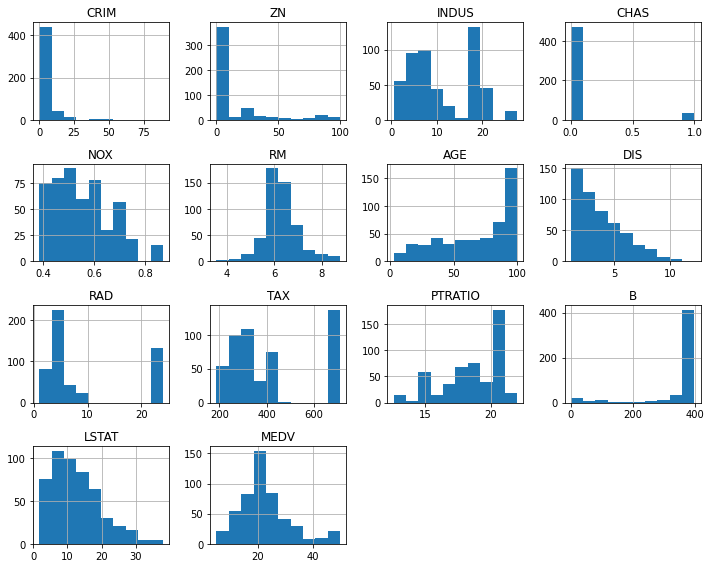

In [9]:
import matplotlib.pyplot as plt
pandas_df = df.toPandas()
pandas_df.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

### UDFs

In [10]:
from snowflake.snowpark.functions import udf
from snowflake.snowpark.types.sf_types import IntegerType, FloatType

def square(x):
    return x * x

@udf(return_type=FloatType(), input_types=[IntegerType()])
def cube_udf(x):
    return square(x) * x

square_udf = udf(square, return_type=FloatType(), input_types=[IntegerType()], name="square")
add_udf = udf(lambda x, y: x + y, return_type=FloatType(), input_types=[IntegerType(), IntegerType()])

In [11]:
df2 = session.createDataFrame([1, 2, 3]).toDF("a")
df2.select("a", square_udf("a"), cube_udf("a"), add_udf(square_udf("a"), cube_udf("a"))).toDF("a", "b", "c", "d").show()

---------------------------
|"A"  |"B"  |"C"   |"D"   |
---------------------------
|1    |1.0  |1.0   |2.0   |
|2    |4.0  |8.0   |12.0  |
|3    |9.0  |27.0  |36.0  |
---------------------------



In [12]:
session.sql("select square(8)").show()

---------------
|"SQUARE(8)"  |
---------------
|64.0         |
---------------



### Simple linear regression UDF with a local dependency

In [13]:
from snowflake.snowpark.types.sf_types import ArrayType
from lr import simple_linear_regression

session.addImports("./lr.py")
linear_regression_udf = udf(simple_linear_regression,
                            return_type=ArrayType(FloatType()),
                            input_types=[ArrayType(FloatType()), ArrayType(FloatType())])

In [14]:
from snowflake.snowpark.functions import array_agg
predictions = df.select(linear_regression_udf(array_agg(col("LSTAT")), array_agg(col("MEDV")))).collect()[0].get_list(0)

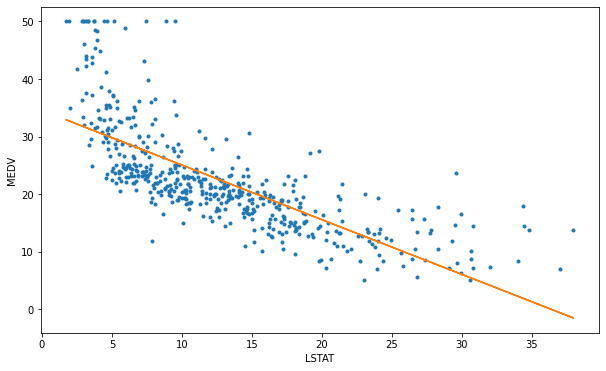

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(pandas_df["LSTAT"], pandas_df["MEDV"], '.')
plt.plot(pandas_df["LSTAT"], predictions)
plt.xlabel("LSTAT")
plt.ylabel("MEDV")
plt.show()

----------------------------------------------------------

In [ ]:
session.close()